In [6]:
import tempfile
from typing import Dict, Iterable, List, Tuple

import allennlp
import torch
from allennlp.data import DataLoader, DatasetReader, Instance, Vocabulary
from allennlp.data.fields import LabelField, TextField
from allennlp.data.token_indexers import TokenIndexer, PretrainedTransformerIndexer
from allennlp.data.tokenizers import Token, Tokenizer, PretrainedTransformerTokenizer
from allennlp.models import Model
from allennlp.modules import TextFieldEmbedder, Seq2VecEncoder
from allennlp.modules.token_embedders import PretrainedTransformerEmbedder
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.seq2vec_encoders import BertPooler
from allennlp.nn import util
from allennlp.training.trainer import GradientDescentTrainer, Trainer
from allennlp.training.optimizers import AdamOptimizer
from allennlp.training.metrics import CategoricalAccuracy

from os.path import join as pathjoin
import pandas as pd
from allennlp.predictors import TextClassifierPredictor
from allennlp.training.metrics import CategoricalAccuracy
import numpy as np

In [7]:
DATA_DIR = '/home/mlepekhin/data'
MODELS_DIR = '/home/mlepekhin/models'
MODEL_ID = 'allennlp_bert_base_cased'
CHECKPOINTS_DIR = pathjoin(MODELS_DIR, MODEL_ID, 'checkpoints')
BEST_MODEL = pathjoin(CHECKPOINTS_DIR, 'best.th')

In [8]:
transformer_model = 'bert-base-cased'
MAX_TOKENS = 510

In [9]:
class SimpleClassifier(Model):
    def __init__(self,
                 vocab: Vocabulary,
                 embedder: TextFieldEmbedder,
                 encoder: Seq2VecEncoder):
        super().__init__(vocab)
        self.embedder = embedder 
        num_labels = vocab.get_vocab_size("labels")
        self.encoder = encoder
        self.classifier = torch.nn.Linear(encoder.get_output_dim(), num_labels)
        self.accuracy = CategoricalAccuracy()
        

    def forward(self,
                text: Dict[str, torch.Tensor],
                label: torch.Tensor=None) -> Dict[str, torch.Tensor]:
        # Shape: (batch_size, num_tokens, embedding_dim)
        embedded_text = self.embedder(text)
        #print("embed shape", embedded_text.shape)
        # Shape: (batch_size, num_tokens)
        mask = util.get_text_field_mask(text)
        #print("mask shape", mask.shape)
        # Shape: (batch_size, encoding_dim)
        encoded_text = self.encoder(embedded_text, mask)
        # Shape: (batch_size, num_labels)
        logits = self.classifier(encoded_text)
        # Shape: (batch_size, num_labels)
        probs = torch.nn.functional.softmax(logits, dim=-1)
        if label is not None:
            loss = torch.nn.functional.cross_entropy(logits, label)
            self.accuracy(logits, label)
            return {'loss': loss, 'probs': probs}
        else:
            return {'probs': probs}
    
    def get_metrics(self, reset: bool = True) -> Dict[str, float]:
        return {"accuracy": self.accuracy.get_metric(reset)}


def read_data(reader: DatasetReader, train_path: str, val_path: str) -> Tuple[Iterable[Instance], Iterable[Instance]]:
    print("Reading data")
    training_data = reader.read(train_path)
    validation_data = reader.read(val_path)
    return training_data, validation_data


def build_vocab(instances: Iterable[Instance]) -> Vocabulary:
    print("Building the vocabulary")
    return Vocabulary.from_instances(instances)


def build_model(vocab: Vocabulary) -> Model:
    print("Building the model")
    vocab_size = vocab.get_vocab_size("tokens")
    #embedder = BasicTextFieldEmbedder(
    #    {"tokens": Embedding(embedding_dim=10, num_embeddings=vocab_size)})
    embedding = PretrainedTransformerEmbedder(model_name=transformer_model)
    embedder = BasicTextFieldEmbedder(token_embedders={'bert_tokens': embedding})
    encoder = BertPooler(transformer_model)
    return SimpleClassifier(vocab, embedder, encoder)

def build_dataset_reader() -> DatasetReader:
    return ClassificationDatasetReader()

def run_training_loop():
    dataset_reader = build_dataset_reader()

    # These are a subclass of pytorch Datasets, with some allennlp-specific
    # functionality added.
    train_data, dev_data = read_data(dataset_reader)

    vocab = build_vocab(train_data + dev_data)
    model = build_model(vocab)

    # This is the allennlp-specific functionality in the Dataset object;
    # we need to be able convert strings in the data to integers, and this
    # is how we do it.
    train_data.index_with(vocab)
    dev_data.index_with(vocab)

    # These are again a subclass of pytorch DataLoaders, with an
    # allennlp-specific collate function, that runs our indexing and
    # batching code.
    train_loader, dev_loader = build_data_loaders(train_data, dev_data)

    # You obviously won't want to create a temporary file for your training
    # results, but for execution in binder for this course, we need to do this.
    with tempfile.TemporaryDirectory() as serialization_dir:
        trainer = build_trainer(
            model,
            serialization_dir,
            train_loader,
            dev_loader
        )
        print("Starting training")
        trainer.train()
        print("Finished training")
    return trainer


# The other `build_*` methods are things we've seen before, so they are
# in the setup section above.
def build_data_loaders(
    train_data: torch.utils.data.Dataset,
    dev_data: torch.utils.data.Dataset,
) -> Tuple[allennlp.data.DataLoader, allennlp.data.DataLoader]:
    # Note that DataLoader is imported from allennlp above, *not* torch.
    # We need to get the allennlp-specific collate function, which is
    # what actually does indexing and batching.
    train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
    dev_loader = DataLoader(dev_data, batch_size=16, shuffle=False)
    return train_loader, dev_loader


def build_trainer(
    model: Model,
    serialization_dir: str,
    train_loader: DataLoader,
    dev_loader: DataLoader,
    num_epochs: int = 1,
    cuda_device: int = -1
) -> Trainer:
    parameters = [
        [n, p]
        for n, p in model.named_parameters() if p.requires_grad
    ]
    optimizer = AdamOptimizer(parameters, lr=0.000025)
    trainer = GradientDescentTrainer(
        model=model,
        serialization_dir=serialization_dir,
        data_loader=train_loader,
        validation_data_loader=dev_loader,
        num_epochs=num_epochs,
        optimizer=optimizer,
        cuda_device=cuda_device,
    )
    return trainer

In [10]:
tokenizer = PretrainedTransformerTokenizer(model_name=transformer_model)
token_indexer = PretrainedTransformerIndexer(model_name=transformer_model)
text = "Hello! I's no more than just my opinion. But I wanted to say you that I don't care"
tokens = tokenizer.tokenize(text)
print("Transformer tokens:", tokens)

Transformer tokens: [[CLS], Hello, !, I, ', s, no, more, than, just, my, opinion, ., But, I, wanted, to, say, you, that, I, don, ', t, care, [SEP]]


In [12]:
class ClassificationDatasetReader(DatasetReader):
    def __init__(self,
                 lazy: bool = False,
                 tokenizer: Tokenizer = None,
                 token_indexers: Dict[str, TokenIndexer] = None,
                 max_tokens: int = None):
        super().__init__(lazy)
        self.tokenizer = tokenizer or PretrainedTransformerTokenizer(transformer_model, max_length=MAX_TOKENS)
        self.token_indexers = token_indexers or {'bert_tokens': PretrainedTransformerIndexer(transformer_model)}
        self.max_tokens = max_tokens
        
    def text_to_instance(self, string: str, label: str = None) -> Instance:
        tokens = self.tokenizer.tokenize(string)
        sentence_field = TextField(tokens, self.token_indexers)
        fields = {"text": sentence_field}
        if label is not None:
            fields["label"] = LabelField(label)
        return Instance(fields)

    def _read(self, file_path: str) -> Iterable[Instance]:
        dataset_df = pd.read_csv(file_path)
        for text, label in zip(dataset_df['text'], dataset_df['target']):
            yield self.text_to_instance(text, label)

### Loading of the pretrained model

In [13]:
vocab = Vocabulary().from_files(pathjoin(MODELS_DIR, MODEL_ID, 'vocab'))

In [14]:
model = build_model(vocab)

Building the model


In [15]:
id_to_label = vocab.get_index_to_token_vocabulary('labels')
print(id_to_label)
print(id_to_label.values())

{0: 'A1', 1: 'A12', 2: 'A7', 3: 'A16', 4: 'A8', 5: 'A22', 6: 'A4', 7: 'A11', 8: 'A14', 9: 'A9', 10: 'A17'}
dict_values(['A1', 'A12', 'A7', 'A16', 'A8', 'A22', 'A4', 'A11', 'A14', 'A9', 'A17'])


In [16]:
if torch.cuda.is_available():
    cuda_device = 0
else:
    cuda_device = -1
print(cuda_device)

0


In [17]:
model.load_state_dict(torch.load(BEST_MODEL))

<All keys matched successfully>

### Data loading

In [18]:
en_test_df = pd.read_csv(pathjoin(DATA_DIR, 'en_test'))
en_test_df.head()

,Unnamed: 0,target,text
0,64,A4,THE PURLOINED LETTER . -----------------------...
1,1575,A7,Judge Finds Probable Cause Against a Greeley p...
2,1254,A11,"Sitting at the bar or in a booth like we did ,..."
3,790,A14,"Keywords : Crystallography , Thermal diffuse Z..."
4,1389,A12,What kind of professional business people can ...


In [19]:
true_classes = en_test_df.target.values
sentences = en_test_df.text.values

### Preliminary analysis

In [20]:
label_description = {
    'A1': 'argum',
    'A3': 'emotive',
    'A4': 'fictive',
    'A5': 'flippant',
    'A6': 'informal',
    'A7': 'instruct',
    'A8': 'reporting',
    'A9': 'legal',
    'A11': 'personal',
    'A12': 'commercial',
    'A13': 'propaganda',
    'A14': 'research',
    'A15': 'specialist',
    'A16': 'info',
    'A17': 'eval',
    'A19': 'poetic',
    'A20': 'appeal',
    'A22': 'stuff'
}

In [21]:
predictor = TextClassifierPredictor(model, dataset_reader=build_dataset_reader())

In [22]:
def predict_classes(sentence_list):
    return [id_to_label[np.argmax(predictor.predict(sentence)['probs'])] for sentence in sentence_list]

In [23]:
predicted_classes = np.array(predict_classes(sentences))

In [24]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [25]:
for label, description in label_description.items():
    true_binary = true_classes == label
    if np.sum(true_binary) == 0:
        continue
    predicted_binary = predicted_classes == label
    print(
        f"label ({description})", 
        f"f1_score {f1_score(predicted_binary, true_binary)}", 
        f"precision {precision_score(predicted_binary, true_binary)}", 
        f"recall {recall_score(predicted_binary, true_binary)}", 
    )
print(f"accuracy", accuracy_score(predicted_classes, true_classes))

label (argum) f1_score 0.6404494382022472 precision 0.7402597402597403 recall 0.5643564356435643
label (fictive) f1_score 0.9090909090909091 precision 0.8928571428571429 recall 0.9259259259259259
label (instruct) f1_score 0.6428571428571429 precision 0.54 recall 0.7941176470588235
label (reporting) f1_score 0.746268656716418 precision 0.6756756756756757 recall 0.8333333333333334
label (legal) f1_score 0.8000000000000002 precision 0.7058823529411765 recall 0.9230769230769231
label (personal) f1_score 0.6046511627906976 precision 0.6842105263157895 recall 0.5416666666666666
label (commercial) f1_score 0.7183098591549295 precision 0.7727272727272727 recall 0.6710526315789473
label (research) f1_score 0.6 precision 0.5217391304347826 recall 0.7058823529411765
label (info) f1_score 0.6666666666666667 precision 0.7631578947368421 recall 0.5918367346938775
label (eval) f1_score 0.8095238095238095 precision 0.7727272727272727 recall 0.85
label (stuff) f1_score 0.7894736842105263 precision 0.66

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

def plot_confusion_matrix(y_model, y_true):
    plt.figure(figsize=(15, 15))
    labels_list = list(id_to_label.values())
    cm = confusion_matrix(y_model, y_true, labels=labels_list)
    sums = np.sum(cm, axis=1)
    normed_cm = (cm.T / sums).T
    sns.heatmap(normed_cm)
    labels_descr = [label_description[label] for label in id_to_label.values()]
    plt.xticks(0.5 + np.arange(len(labels_list)), labels=labels_descr, fontsize=12)
    plt.yticks(0.5 + np.arange(len(labels_list)), labels=labels_descr, fontsize=12)

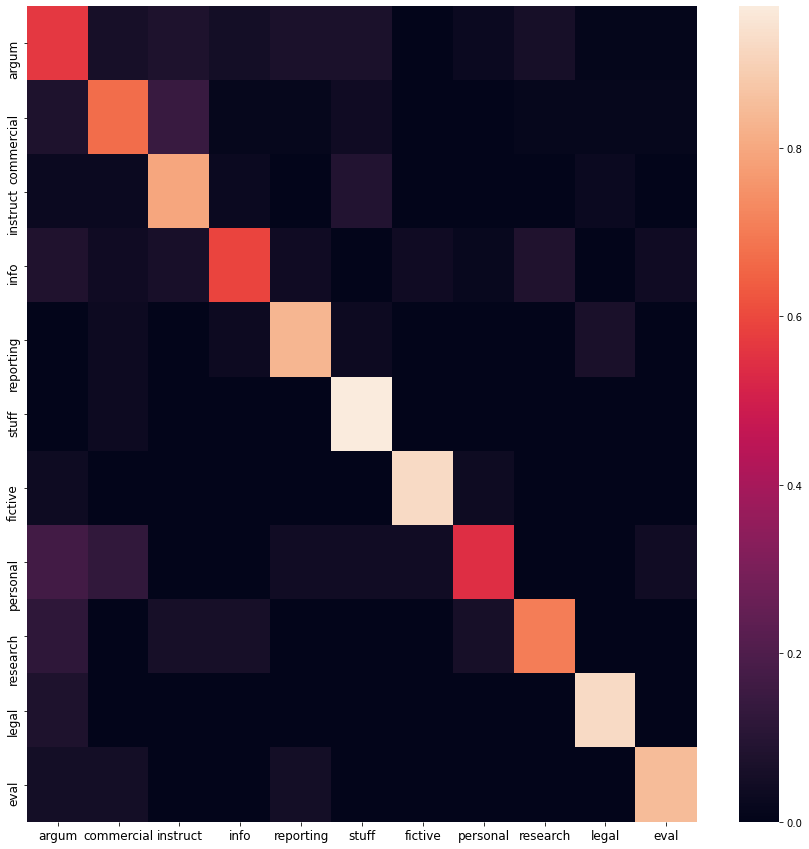

In [27]:
plot_confusion_matrix(predicted_classes, true_classes)

### Saliency Gradient Interpretation

In [ ]:
from allennlp.interpret.saliency_interpreters import SmoothGradient, SimpleGradient, IntegratedGradient

In [28]:
smooth_grad = SmoothGradient(predictor)
simple_grad = SimpleGradient(predictor)
integrated_grad = IntegratedGradient(predictor)

In [37]:
def run_interpreter(sentence, tokens, k, interpreter):
    vec = np.array(interpreter.saliency_interpret_from_json({"sentence": sentence})['instance_1']['grad_input_1'])
    important_indices = set(vec.argsort()[-k:])
    
    print(type(interpreter), "TEXT:")
    for token_id, token in enumerate(tokens):
        if token_id in important_indices:
            print(colored(token , "red"), end=' ')
        else:
            print(token, end=' ')
    print("\n")

In [38]:
from termcolor import colored

def interpret_sentence(sentence, k, interpreters=[], true_label=None, label=None):
    if true_label is not None:
        print("TRUE LABEL:", true_label)
    if label is not None:
        print("LABEL:", label)
    
    tokens = tokenizer.tokenize(sentence)[1:511]
    k = min(k, len(tokens))
    for interpreter in interpreters:
        run_interpreter(sentence, tokens, k, interpreter)

In [39]:
mistake_ids = []

for sent_id in range(len(true_classes)):
    if true_classes[sent_id] != predicted_classes[sent_id]:
        mistake_ids.append(sent_id)

In [40]:
interpret_sentence(
    sentences[mistake_ids[0]], 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[0]]],
    label_description[predicted_classes[mistake_ids[0]]]
)

TRUE LABEL: instruct
LABEL: argum
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
Judge Find ##s Pro ##ba ##ble Cause Against a G ##ree ##ley police Officer A judge has found probable cause to have a trial in the sexual assault trial of a police officer charged with g ##rop ##ing a female driver he had stopped . The story in the Tribune also said the officer changed his story about not stopping the driver at all , when GPS records for his vehicle placed him at the site of the incident . This is just some of the procedures that the state and attorney for the defense go through in our criminal justice system . If you have been arrested for an assault , sexual or otherwise you can hire an expert to defend you . You can get a Colorado criminal defense attorney . In the case cited , the defendant ' s attorney filed a motion to dismiss the charges due to no probable cause . As happens , the aspects of a simple sexual assault case such as this sometimes

In [41]:
interpret_sentence(
    sentences[mistake_ids[1]], 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[1]]],
    label_description[predicted_classes[mistake_ids[1]]]
)

TRUE LABEL: research
LABEL: info
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
Key ##words : Crystal ##log ##raphy , The ##rmal di ##ff ##use Z ##in ##c ##ble ##nde structure , Diamond structure , Solid state physics , X - ray scattering , I ##ii - v compounds , Silicon , La ##tti ##ce dynamics , T ##ds , I ##i - v ##i compounds , I - v ##ii compounds . Classification : 7 . 8 , 8 . Nature of problem : Det ##er ##mination of single - p ##hon ##on di ##ff ##use X - ray scattering in lines , areas or volumes of re ##ci ##p ##ro ##cal space at any temperature , using e ##ige ##nda ##ta given by a lattice dynamic ##al model . Evaluation of contribution to one - p ##hon ##ons ##cat ##tering from ion ##ic def ##orm ##ations , modelled by a shell model . Sol ##ution method : The elements of the anal ##ytic solution are assembled from a combination of input data , ta ##bula ##ted scattering factors and transformation of a minimum set of e ##ige ##nda ##

In [42]:
interpret_sentence(
    sentences[mistake_ids[2]], 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[2]]],
    label_description[predicted_classes[mistake_ids[2]]]
)

TRUE LABEL: commercial
LABEL: argum
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
What kind of professional business people can benefit from using a 24 - hour message service ? Is it only for Doctor ' s and Den ##tist ' s Office ##s ? Would other profession ##s benefit from having a live reception ##ist answer their phone 24 hours a day , 7 days a week ? Let ' s take a look at that . The Office is a different place , these days . It ' s no longer a big building , with cu ##bby holes , and small partition ##s . An office nowadays is anywhere you set up your computer , or hold your cell phone . A lot of business people have now moved their offices into their own homes . Most people do n ' t have room for a reception ##ist in their bedroom , or kitchen , and would n ' t be able to afford the full - time salary anyway . But , there are a lot of reasons an answering service would be a work ##able solution for fields other than medical and dental . A

### Text Attacking

In [43]:
from allennlp.interpret.attackers import Hotflip, InputReduction

In [45]:
hotflip = Hotflip(predictor)
input_reduction = InputReduction(predictor)

In [79]:
instance = predictor._json_to_instance({'sentence': sentences[0], 'tokens': tokenizer.tokenize(sentences[0])})
print(instance)

Instance with fields:
 	 text: TextField of length 512 with text: 
 		[[CLS], THE, P, ##UR, ##L, ##O, ##IN, ##ED, L, ##ET, ##TE, ##R, ., -, -, -, -, -, -, -, -, -, -, -,
		-, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -,
		-, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -, -,
		-, -, -, Ni, ##l, sa, ##pie, ##nti, ##ae, o, ##dio, ##sius, a, ##cum, ##ine, ni, ##mio, ., Seneca,
		., At, Paris, ,, just, after, dark, one, g, ##ust, ##y, evening, in, the, autumn, of, 18, –, ,, I,
		was, enjoying, the, two, ##fold, luxury, of, meditation, and, a, me, ##ers, ##cha, ##um, ,, in,
		company, with, my, friend, C, ., Auguste, Du, ##pin, ,, in, his, little, back, library, ,, or, book,
		-, closet, ,, au, t, ##rois, ##ie, ##me, ,, No, ., 33, ,, Rue, Du, ##not, ,, F, ##au, ##bourg, St,
		., Germain, ., For, one, hour, at, least, we, had, maintained, a, profound, silence, ;, while, each,
		,, to, any, casual,

In [81]:
output_dict = predictor._model.forward_on_instance(instance)
print(output_dict)
original_instances = predictor.predictions_to_labeled_instances(instance, output_dict)
print(original_instances[0].fields)

{'probs': array([2.8660509e-03, 5.2693737e-04, 4.2604172e-04, 7.0777995e-04,
       5.6685478e-04, 1.1071034e-03, 9.7311223e-01, 1.1906536e-02,
       1.5367509e-03, 2.1526413e-03, 5.0911000e-03], dtype=float32)}
{'text': <allennlp.data.fields.text_field.TextField object at 0x7fb99c04ac40>, 'label': <allennlp.data.fields.label_field.LabelField object at 0x7fb99c04ae40>}


In [87]:
input_reduction.attack_from_json(
    inputs={
        'sentence': sentences[0], 
        #'tokens': tokenizer.tokenize(sentences[0])
    },
    input_field_to_attack='text',
)

TypeError: cannot pickle 'Tokenizer' object